# Applying Binary Model to Test and Real Data

In [1]:
### python packages
import os
from os import path
import numpy as np
import glob as glob
from random import random
import pandas as pd
import pickle
import time

### torch packages
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import Sampler

### sklearn packages
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold


### remove these later (for notebook version only)
'''
from tqdm import tqdm_notebook as tqdm
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, export_png
from bokeh.layouts import row
output_notebook()
'''
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

torch.cuda.manual_seed(42)


def GetSimData(file):

    ### grab local and global views
    data_global = np.nan_to_num(np.load(file.replace('_info2.npy','_glob.npy'),encoding='latin1'))
    data_local = np.nan_to_num(np.load(file.replace('_info2.npy','_loc.npy'),encoding='latin1'))

    ### grab centroid views
    data_global_cen = data_global[:,1][np.newaxis,:]
    data_local_cen = data_local[:,1][np.newaxis,:]

    data_global = data_global[:,0][np.newaxis,:]
    data_local = data_local[:,0][np.newaxis,:]

    ### info file contains: [0]kic, [1]tce, [2]period, [3]epoch, [4]duration, [5]label)
    data_info = np.load(file,encoding='latin1')
    #np.load(self.flist_info[idx],encoding='latin1')

    if data_info[6]=='PL':
        label=1
    else:
        label=0

    #collist=['TPERIOD','TDUR','DRRATIO','NTRANS','TSNR','TDEPTH','INDUR',
    #         'SESMES_LOG_RATIO','PRAD_LOG_RATIO','TDUR_LOG_RATIO','RADRATIO','IMPACT',
    #         'TESSMAG','RADIUS','PMTOTAL','LOGG','MH','TEFF']#from bls search, derived from transit model, from starpars
    stelpars=np.nan_to_num(np.hstack((data_info[7:13].astype(float),data_info[-18:-6].astype(float))))[np.newaxis,:]

    return (data_local.astype(float), data_global.astype(float), data_local_cen.astype(float), data_global_cen.astype(float), stelpars), label

def GetRealData(file):
    ### grab local and global views
    data_global = np.nan_to_num(np.load(file.replace('_info2.npy','_glob.npy'),encoding='latin1'))
    data_local = np.nan_to_num(np.load(file.replace('_info2.npy','_loc.npy'),encoding='latin1'))

    ### grab centroid views
    data_global_cen = data_global[:,1][np.newaxis,:]
    data_local_cen = data_local[:,1][np.newaxis,:]

    data_global = data_global[:,0][np.newaxis,:]
    data_local = data_local[:,0][np.newaxis,:]

    ### info file contains: [0]kic, [1]tce, [2]period, [3]epoch, [4]duration, [5]label)
    data_info = np.load(file,encoding='latin1')
    #np.load(self.flist_info[idx],encoding='latin1')

    #collist=['TPERIOD','TDUR','DRRATIO','NTRANS','TSNR','TDEPTH','INDUR',
    #         'SESMES_LOG_RATIO','PRAD_LOG_RATIO','TDUR_LOG_RATIO','RADRATIO','IMPACT',
    #         'TESSMAG','RADIUS','PMTOTAL','LOGG','MH','TEFF']#from bls search, derived from transit model, from starpars
    newixs=np.array([16, 24, 17, 30, 31, 21])
    stelpars=np.nan_to_num(np.hstack((data_info[newixs].astype(float),data_info[-18:-6].astype(float))))[np.newaxis,:]

    return (data_local.astype(float), data_global.astype(float), data_local_cen.astype(float), data_global_cen.astype(float), stelpars), np.nan


class Model(nn.Module):

    '''
    
    PURPOSE: DEFINE EXTRANET MODEL ARCHITECTURE
    INPUT: GLOBAL + LOCAL LIGHT CURVES AND CENTROID CURVES, STELLAR PARAMETERS
    OUTPUT: BINARY CLASSIFIER
    
    '''
    
    def __init__(self):

        ### initialize model
        super(Model, self).__init__()

        ### define global convolutional lalyer
        self.fc_global = nn.Sequential(
            nn.Conv1d(2, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),
            nn.Conv1d(16, 32, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),
            nn.Conv1d(32, 64, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(64, 64, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),
            nn.Conv1d(64, 128, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 128, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),
            nn.Conv1d(128, 256, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(256, 256, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),
        )

        ### define local convolutional lalyer
        self.fc_local = nn.Sequential(
            nn.Conv1d(2, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(7, stride=2),
            nn.Conv1d(16, 32, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(7, stride=2),
        )

        ### define fully connected layer that combines both views
        self.final_layer = nn.Sequential(
            nn.Linear(7858, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid())

    def forward(self, x_local, x_local_cen, x_global, x_global_cen, x_star):
        
        x_local_all = torch.cat([x_local, x_local_cen], dim=1)
        x_global_all = torch.cat([x_global, x_global_cen], dim=1)

        ### get outputs of global and local convolutional layers
        out_global = self.fc_global(x_global_all)
        out_local = self.fc_local(x_local_all)
        
        ### flattening outputs (multi-dim tensor) from convolutional layers into vector
        out_global = out_global.view(out_global.shape[0], -1)
        out_local = out_local.view(out_local.shape[0], -1)

        ### join two outputs together
        out = torch.cat([out_global, out_local, x_star.squeeze(1)], dim=1)
        out = self.final_layer(out)

        return out
    

In [2]:
allmodels={}
for k in range(8):
    foldname    = "/home/hosborn/TESS/final_runs/exonet_binary_CV_globcents3b_k8_2"
    savename    = "exonet_CV_"+str(k)+".8_101_all_Big"
    savedicname = "exonet_binary_CV_globcents3b_k8_2_dic"
    mod         = "Big"
    aug         = "all"
    fpath       = "101"

    allmodels[k]=Model().cuda()
    lr = 1.5e-5

    optimizer = torch.optim.Adam(allmodels[k].parameters(), lr=lr)
    criterion = nn.BCELoss()
    batch_size = 64
    n_epochs = 200
    
    #LOADING MODEL STATE:
    allmodels[k].load_state_dict(torch.load(path.join(foldname,savename.replace('_comp','')+'_best.pth')))

### NEED TO PROCESS pickle FILES INTO info2 FILES
### NEED TO WHITEN TEST DATA

In [5]:
dataloaders={'real':glob.glob('/home/hosborn/TESS/Processed_RealDat_2/*info2.npy'),
             'real_nan':glob.glob('/home/hosborn/TESS/Processed_RealDat_2/nans/*info2.npy'),
             'test':glob.glob('/home/hosborn/TESS/processed_dv_101_centfixed2/test/*info2.npy')}#,'nan':nan_data_loader
model_output={}

for data_loader in dataloaders:
    print(data_loader)
    model_output[data_loader]=pd.DataFrame()
    
    for file in dataloaders[data_loader]:
        if data_loader=='test':
            x_data, ys = GetSimData(file)
        else:
            x_data, ys = GetRealData(file)

        ### get local view, global view, and label for training
        x_local, x_global, x_local_cent,x_global_cent, x_star = x_data

        x_local = Variable(torch.from_numpy(x_local)).type(torch.FloatTensor).cuda().unsqueeze(1)
        x_local_cent = Variable(torch.from_numpy(x_local_cent)).type(torch.FloatTensor).cuda().unsqueeze(1)
        x_global = Variable(torch.from_numpy(x_global)).type(torch.FloatTensor).cuda().unsqueeze(1)
        x_global_cent = Variable(torch.from_numpy(x_global_cent)).type(torch.FloatTensor).cuda().unsqueeze(1)
        x_star = Variable(torch.from_numpy(x_star)).type(torch.FloatTensor).cuda().unsqueeze(1)
        
        preds={}
        for k in allmodels:
            ### Looping through each model to predict:            
            preds[str(k)]=allmodels[k](x_local, x_local_cent, x_global, x_global_cent, x_star).cpu().detach().numpy().ravel()[0]
        if data_loader is 'test':
            preds['gt']=ys
        model_output[data_loader] = model_output[data_loader].append(pd.Series(preds,name=file.split('/')[-1][:18]))
    allks=model_output[data_loader][[str(k) for k in range(8)]].values
    model_output[data_loader]['med'] = np.median(allks,axis=1)
    model_output[data_loader]['av'] = np.average(allks,axis=1)
    if data_loader is 'test':
        labels=['UNK','PL']
        onehot=make_one_hot(model_output['test']['gt'].values.astype(int),2)
        avvals=np.column_stack((1.0-model_output['test']['av'].values,model_output['test']['av'].values))
        print("AP:",average_precision_score(onehot,avvals))
        for n in range(2):
            print(labels[n]," AV accuracy:",np.sum((np.argmax(avvals,axis=1)==n)*onehot[:,n].astype(bool))/np.sum(np.argmax(avvals,axis=1)==n))
            print(labels[n]," AV recall:",np.sum((np.argmax(avvals,axis=1)==n)*onehot[:,n].astype(bool))/np.sum(onehot[:,n]))
            print(labels[n]," AV A.P.:", average_precision_score(onehot,avvals,average=None)[n])

real_nan
test
AP: 0.97277438364112
UNK  AV accuracy: 0.9763819095477387
UNK  AV recall: 0.984794728839331
UNK  AV A.P.: 0.9935775502451326
PL  AV accuracy: 0.9184782608695652
PL  AV recall: 0.8779220779220779
PL  AV A.P.: 0.9519712170371073
real


In [ ]:
ap: 0.9557892461233882

In [6]:
pickle.dump(model_output,open('binarymod.pickle','wb'))

In [4]:
def make_one_hot(labels, C=2):
    '''
    Converts an integer label torch.autograd.Variable to a one-hot Variable.
    
    Parameters
    ----------
    labels : torch.autograd.Variable of torch.cuda.LongTensor
        N x 1 x H x W, where N is batch size. 
        Each value is an integer representing correct classification.
    C : integer. 
        number of classes in labels.
    
    Returns
    -------
    target : torch.autograd.Variable of torch.cuda.FloatTensor
        N x C x H x W, where C is class number. One-hot encoded.
    '''
    if type(labels)==list or type(labels)==np.ndarray:
        target=np.zeros((len(labels),C))
        target[np.arange(len(labels)), np.array(labels).astype(int)] = 1
    else:
        one_hot = torch.cuda.FloatTensor(labels.size(0), C, labels.size(2), labels.size(3)).zero_()
        target = one_hot.scatter_(1, labels.data, 1)

        target = Variable(target)
        
    return target


AP: 0.9755840287549226
UNK  AV accuracy: 0.9803229061553986
UNK  AV recall: 0.984794728839331
UNK  AV A.P.: 0.9953788113864569
PL  AV accuracy: 0.9202127659574468
PL  AV recall: 0.8987012987012987
PL  AV A.P.: 0.9557892461233882


In [14]:
avallks.shape

(2358, 2)

In [10]:
model_output['test']['gt'].values.astype(int)

array([1., 0., 0., ..., 0., 0., 0.])

In [66]:
np.save('realdat_binarymod.npy',model_output['real'])
np.save('realdat_binarymod_nans.npy',model_output['real_nan'])

In [8]:
pickle.dump(model_output,open('binarymod.pickle','wb'))

In [69]:
average_precision_score?
#(gt,)

In [75]:
average_precision_score(gt,model_output[data_loader]['av'],average='micro')

0.9557892461233882

In [77]:
print("recall:",np.sum((model_output['test']['av']>0.5)*(gt==1))/np.sum(gt==1))
print("accuracy:",np.sum((model_output['test']['av']>0.5)*(gt==1))/np.sum(model_output['test']['av']>0.5))

print("recall:",np.sum((model_output['test']['av']<0.5)*(gt==0))/np.sum(gt==0))
print("accuracy:",np.sum((model_output['test']['av']<0.5)*(gt==0))/np.sum(model_output['test']['av']<0.5))

recall: 0.8987012987012987
accuracy: 0.9202127659574468
recall: 0.984794728839331
accuracy: 0.9803229061553986


recall: 0.984794728839331
accuracy: 0.9803229061553986


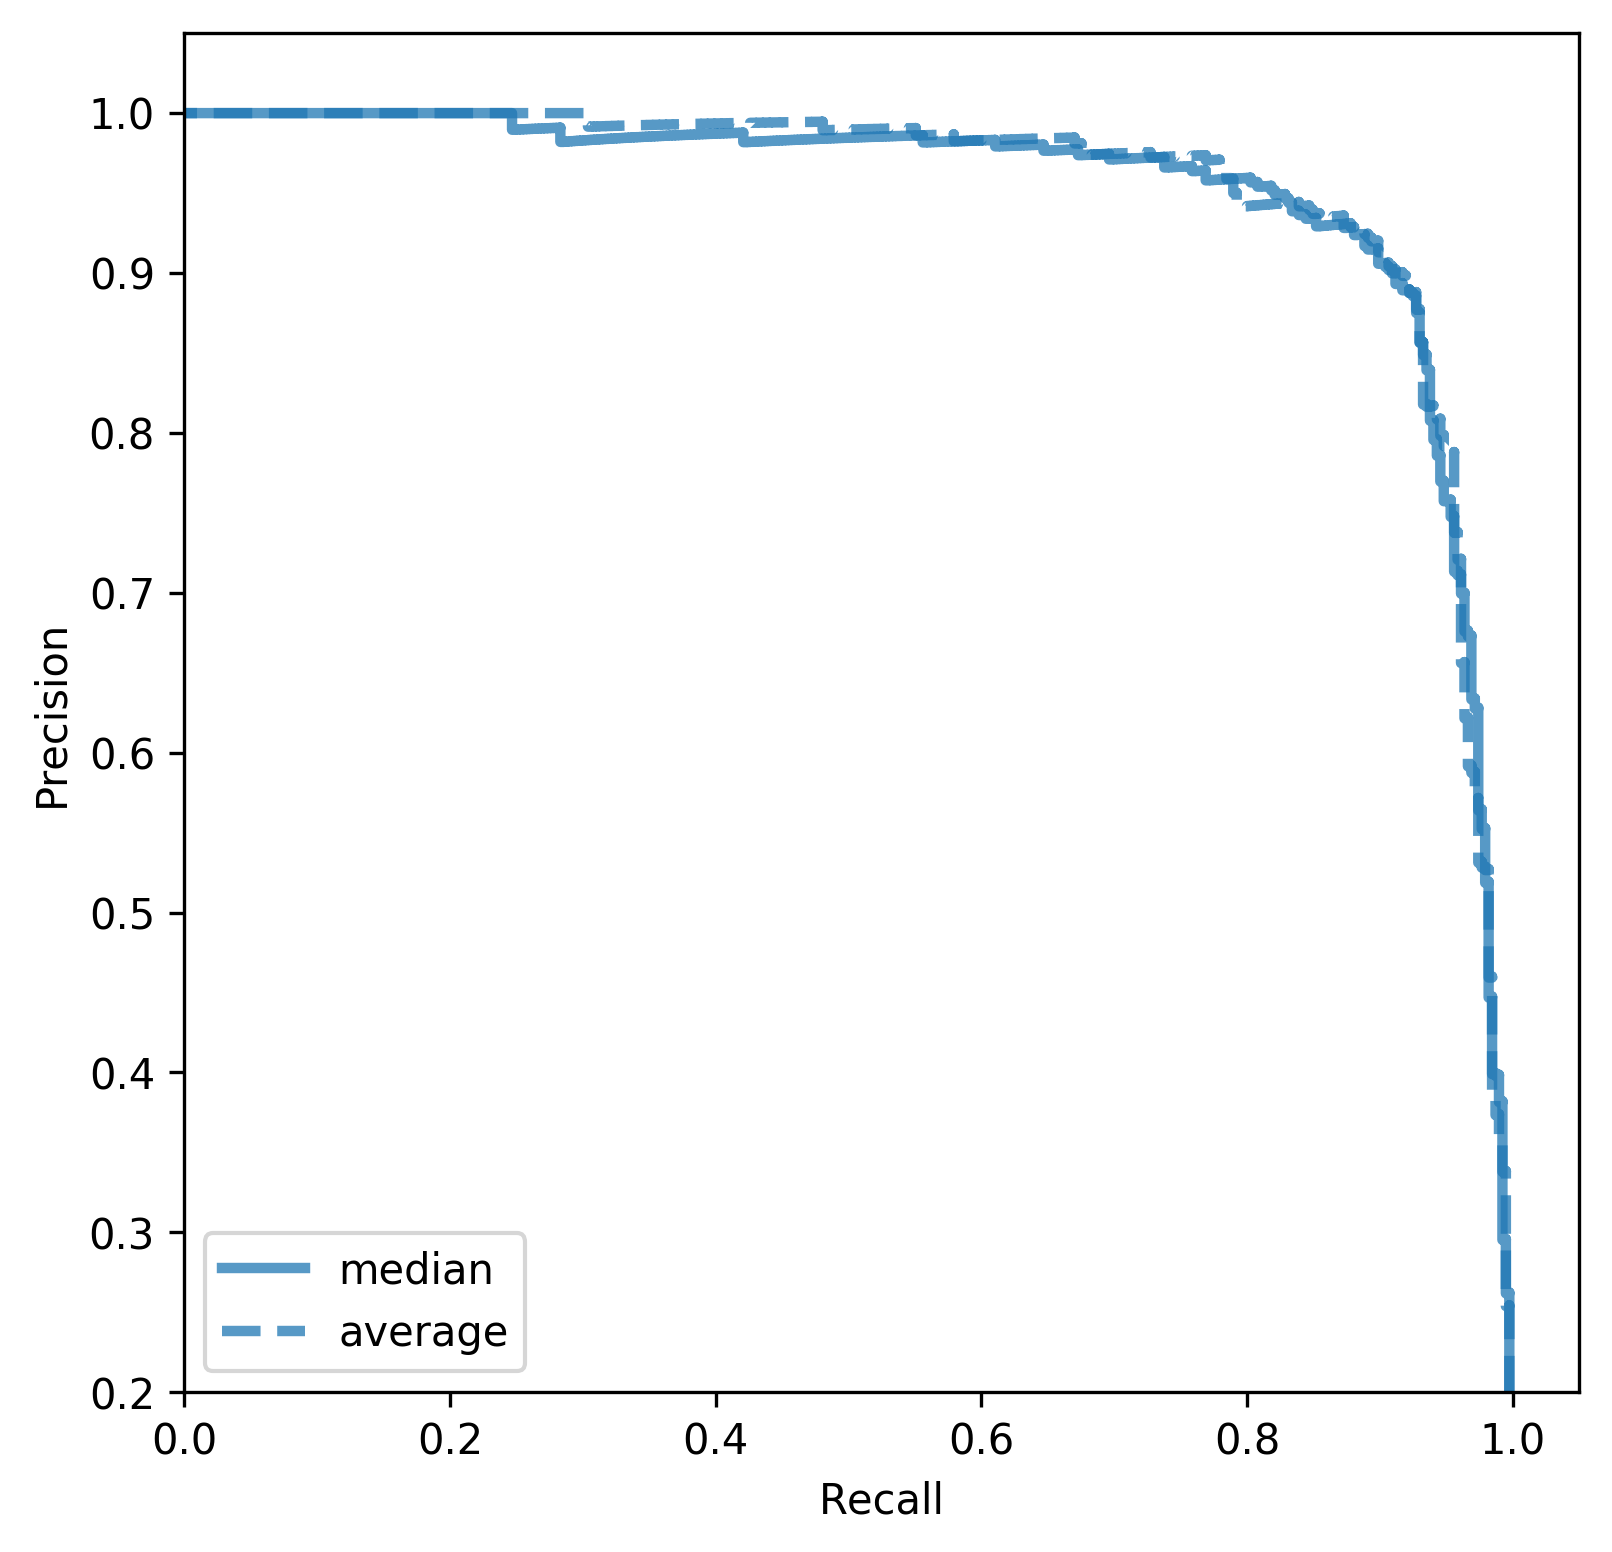

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300

savefile='Binary_ensemble_testdat_avmedcomp.png'

gt=model_output['test']['gt']

plt.figure(figsize=(6,6))
labels=['PL']
P, R, _ =precision_recall_curve(gt,model_output['test']['med'])
steps=plt.step(R, P,linewidth=2.5,label='median',alpha=0.75)
P, R, _ =precision_recall_curve(gt,model_output['test']['av'])
plt.step(R, P,linewidth=2.5,label='average',linestyle='--',color=steps[0].get_color(),alpha=0.75)

plt.legend()
plt.xlim(0.0,1.05)
plt.ylim(0.2,1.05)
plt.xlabel('Recall')
plt.ylabel('Precision')
savefile='Binary_ensemble_testdat_avmedcomp'
plt.savefig(path.join('/home/hosborn/TESS/PaperFigures',savefile+'_PR.png'))
plt.savefig(path.join('/home/hosborn/TESS/PaperFigures',savefile+'_PR.pdf'))

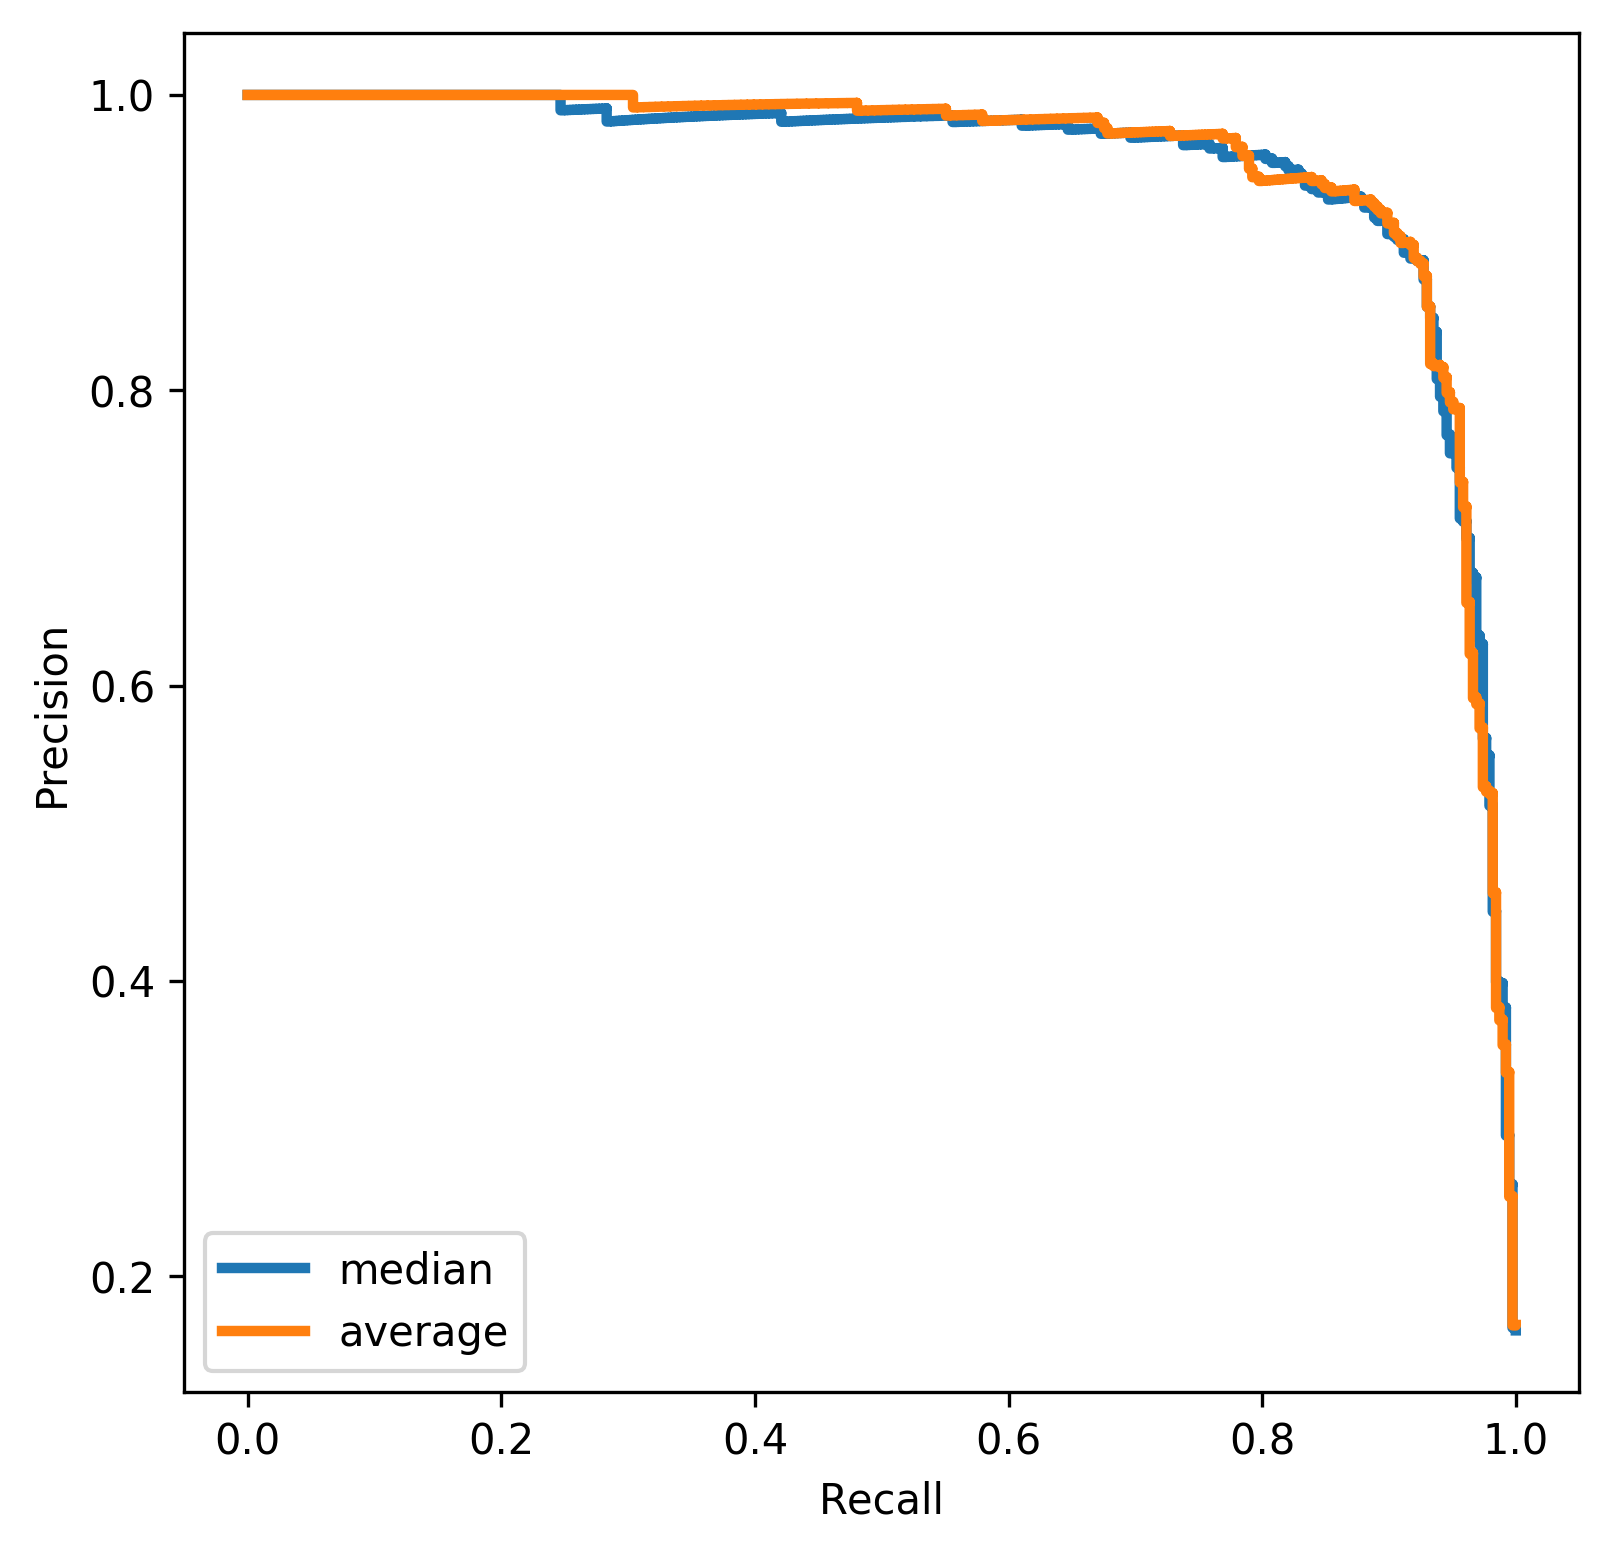

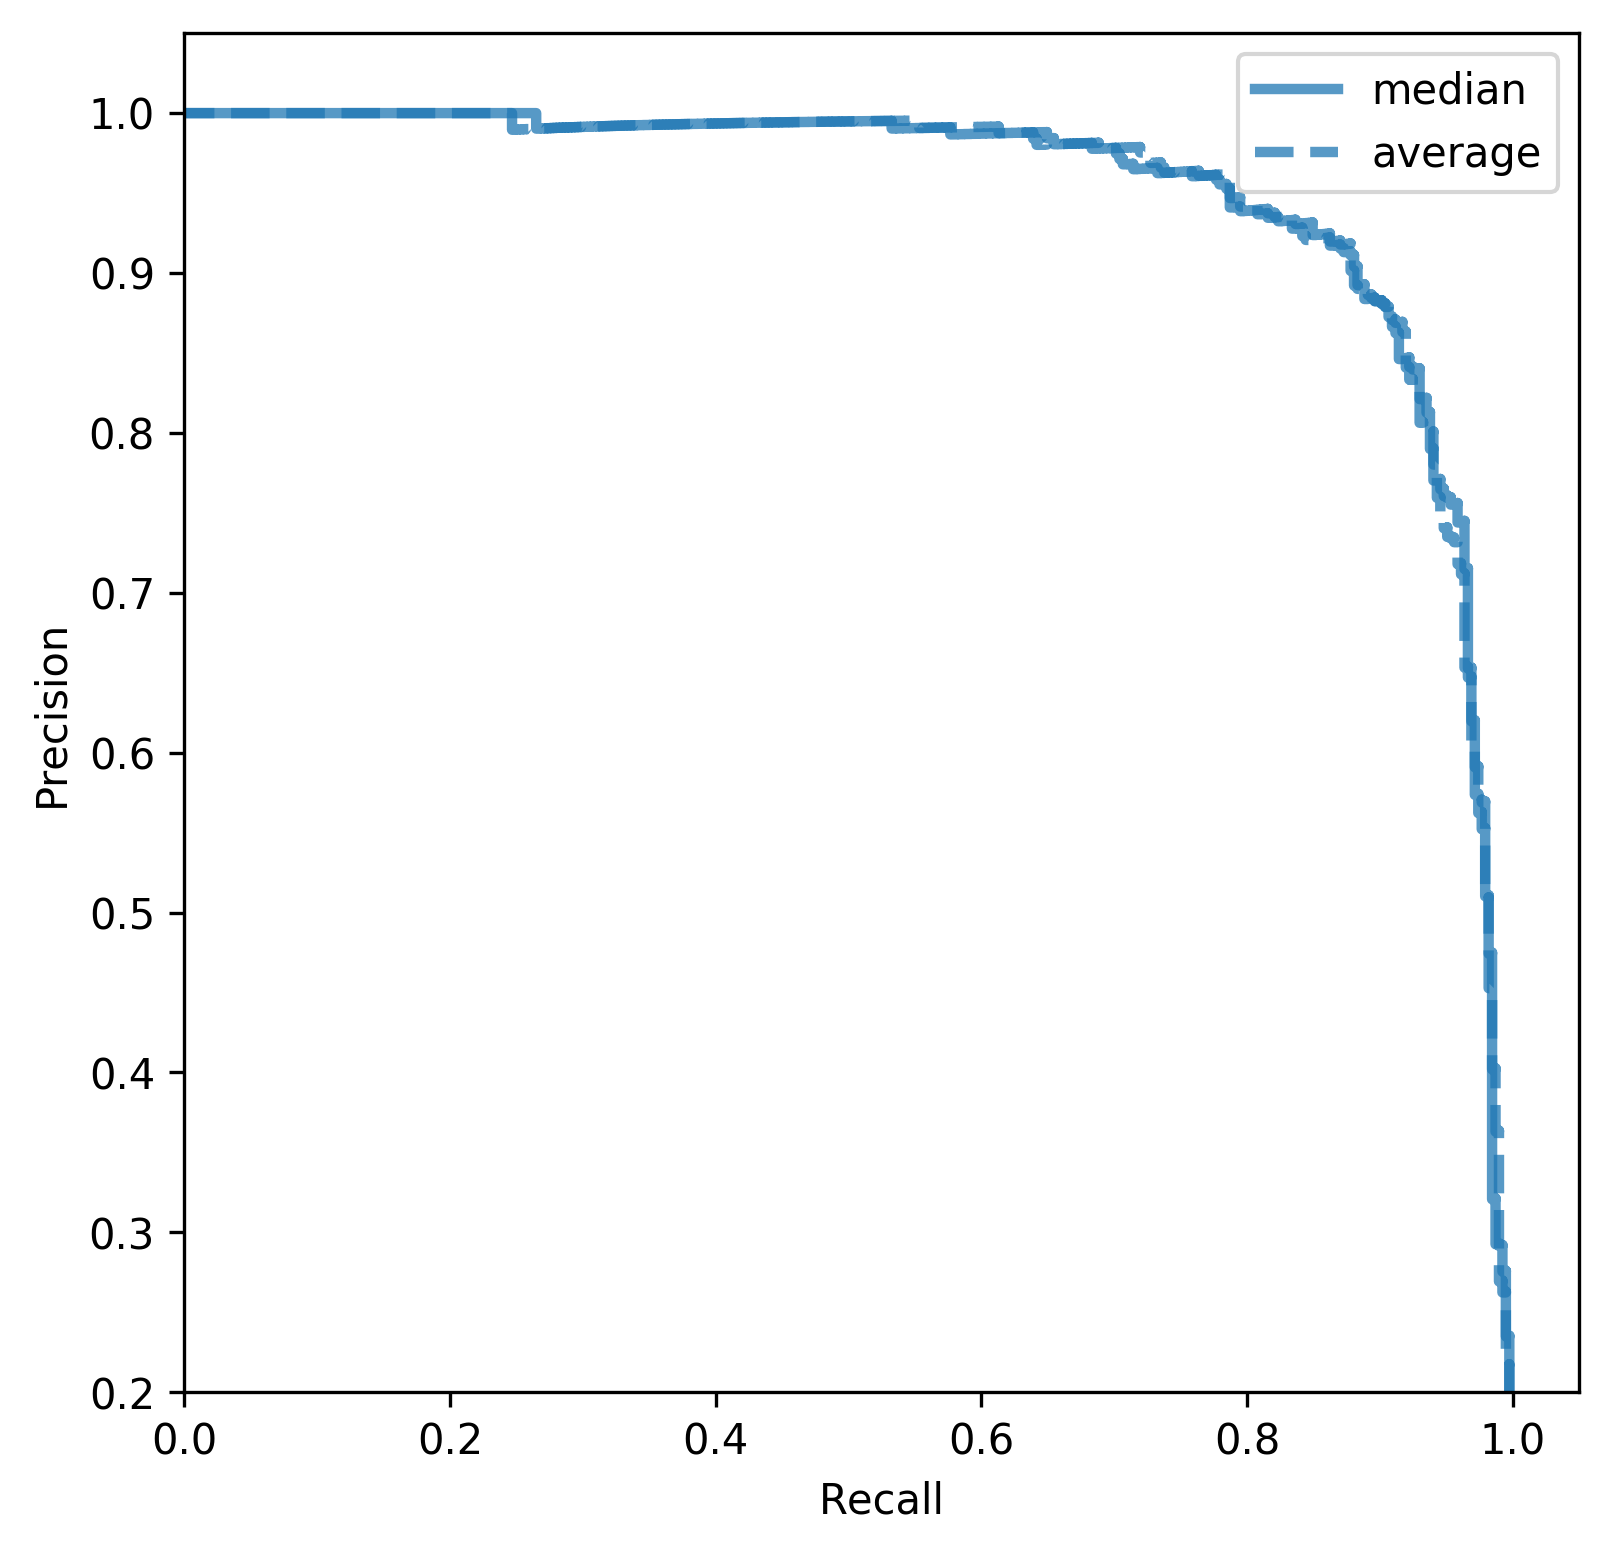

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300

savefile='Binary_ensemble_testdat_avmedcomp.png'

gt=model_output['test']['gt']

plt.figure(figsize=(6,6))
labels=['PL']
P, R, _ =precision_recall_curve(gt,model_output['test']['med'])
steps=plt.step(R, P,linewidth=2.5,label='median',alpha=0.75)
P, R, _ =precision_recall_curve(gt,model_output['test']['av'])
plt.step(R, P,linewidth=2.5,label='average',linestyle='--',color=steps[0].get_color(),alpha=0.75)

plt.legend()
plt.xlim(0.0,1.05)
plt.ylim(0.2,1.05)
plt.xlabel('Recall')
plt.ylabel('Precision')
savefile='Binary_ensemble_testdat_avmedcomp_2'
plt.savefig(path.join('/home/hosborn/TESS/PaperFigures',savefile+'_PR_2.png'))
plt.savefig(path.join('/home/hosborn/TESS/PaperFigures',savefile+'_PR_2.pdf'))